## <center>Проект: Исследование рынка заведений общественного питания Москвы<br>
---

#### <article id="back">
## __Навигация__
  
<br><a href="#part0.0">Задача</a>
<br><a href="#part0.1">Описание данных</a>
<br>Шаг 1. Загрузка и подготовка к анализу
<br><a href="#part11">Шаг 1.1 Обзор общей информации о данных</a>
<br><a href="#part12">Шаг 1.2 Подготовка данных</a>
<br><a href="#part2">Шаг 2. Анализ данных</a>
<br><a href="#part3">Шаг 3. Общий вывод</a>


<article id="part0.0">
<h2>Задача
</article>

Проанализировать рынок заведений общественного питания в Москве на основе открытых данных и ответить на вопросы и дать рекомендации для открытия нового кафе:
    - оценить текущее положение дел на рынке;
    - выделить наиболее перспективный вид заведения;
    - выделить наиболее распространенное количество посадочных мест;
    - выделить наиболее популярный район расположения;


<article id="part0.1">
<h2>Описание данных
</article>

Таблица rest_data:
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест

<a href="#back">В начало</a>

<article id="part1">
<h2>Шаг 1. Загрузка и подготовка к анализу
</article>

<article id="part11">
<h3>Шаг 1.1 Обзор общей информации о данных
</article>

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np


import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-darkgrid')

import seaborn as sns

import requests
from bs4 import BeautifulSoup
from io import BytesIO 

import warnings
warnings.simplefilter("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
rest_msc = pd.read_csv('.../rest_data.csv')

In [3]:
def show_info(df):
    """
    Отображает первые 3х строки датафрейма, кол-во дубликатов и информацию о датафрейме
    """
    display(df.head(3))
    print('Кол-во полных дубликатов:{}'.format(df.duplicated().sum()))
    print()
    display(df.info())
    display(df.describe())

In [4]:
show_info(rest_msc)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95


Кол-во дубликатов:0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


None

,id,number
count,15366.00,15366.00
mean,119720.07,59.55
std,73036.13,74.74
min,838.00,0.00
25%,28524.00,12.00
50%,144974.50,40.00
75%,184262.25,80.00
max,223439.00,1700.00


Вывод по данным: 
- Пропусков и полных дубликатов в данных нет — проверить неполные дубликаты
- Убрать слова "кафе", "ресторан" и тд из названий
- Проверить количество посадочных мест 0 (это бары без мест или ошибка?) и 1700 (это столовая или ошибка?)

<a href="#back">В начало</a>

<article id="part12">
<h3>Шаг 1.2 Подготовка данных
</article>

#### Предобработка названий и типов объектов

In [5]:
print('кол-во уникальных названий мест до предобработки:', rest_msc['object_name'].nunique())

кол-во уникальных названий мест до предобработки: 10393


Избавляемся от наиболее очевидных избыточных слов и знаков в названии — например, когда в названии прописан тип заведения "кафе Х" и приводим к нижнему регистру все записи.

In [6]:
object_name_di = '|'.join(['«', '»', ',', "'", 'кафе ', 'буфет ', 'кальянная ', 'ресторан ', 'бар ', 'закусочная ', 'предприятие быстрого обслуживания ', 'предприятие быстрого питания '])

In [7]:
rest_msc['object_name'] = (rest_msc['object_name']
                           .str.lower()
                           .str.replace(object_name_di, '')
                           .str.strip()
                          )

Также удаляем все места со статусом "закрыто".

In [8]:
print('кол-во мест со статусом "закрыто":', rest_msc[rest_msc['object_name'].str.contains('закрыт')]['id'].count())
rest_msc = rest_msc[~rest_msc['object_name'].str.contains('закрыт')]

кол-во мест со статусом "закрыто": 29


Удаляем неполные дубликаты: строки, для которых дублируется Название места+адрес. Считаем эти строки задвоением, так как вероятность того, что по одному адресу будет несколько разных мест с одним и тем же названием невелика.

In [9]:
print('кол-во точек для которых дублируется сочетание названия места и адреса:', rest_msc.duplicated(['object_name', 'address']).sum())
rest_msc = rest_msc.drop_duplicates(['object_name', 'address']).reset_index(drop=True)

кол-во точек для которых дублируется сочетание названия места и адреса: 244


Для удобства заменяем названия типов объектов:
- 'предприятие быстрого обслуживания' = 'фаст-фуд'
- 'магазин (отдел кулинарии)' = 'отдел кулинарии'

In [10]:
object_type_di = {'предприятие быстрого обслуживания': 'фаст-фуд', 'магазин (отдел кулинарии)': 'отдел кулинарии'}
rest_msc['object_type'] = rest_msc['object_type'].replace(object_type_di)

Для многих заведений с одним названием присвоены различные типы объектов. Считаем это ошибкой, так как если кафе открывает новый формат, обычно название тоже меняется, например добавляется "express" или "мини".

Создаем словарь Название+тип объекта. Тип объекта выбираем как наиболее часто встречающийся для этого названия. Словарь создаем для топ-300 мест по количеству точек для упрощения и ускорения работы. Считаем, что это исправит основную часть несоответствий, так как разные типы объектов могут быть только у крупных сетевых ресторанов (где есть простор для ошибки).

In [11]:
name_type_dict = (rest_msc
                  .groupby(['object_name', 'object_type'])
                  .agg(rest_number = ('id', 'count'))
                  .sort_values(by = ['rest_number'], ascending = False)
                  .head(300)
                  .reset_index()
                  .pivot_table(index = ['object_name'], values = 'object_type', aggfunc = 'first')
                  .reset_index()
                 )

In [12]:
for row in name_type_dict['object_name']:
    rest_msc.loc[(rest_msc['object_name'] == row), 'object_type'] = name_type_dict.loc[name_type_dict['object_name'] == row, 'object_type'].array[0]

In [13]:
print('кол-во уникальных названий мест после предобработки:', rest_msc['object_name'].nunique())

кол-во уникальных названий мест после предобработки: 9345


#### Обработка данных о кол-ве посадочных мест

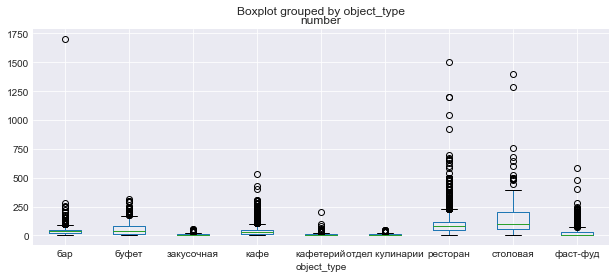

In [14]:
rest_msc.boxplot('number', by = 'object_type', figsize = (10, 4));

В данных по количеству посадочных мест явно есть выбросы: например, бар с 1750 посадочных мест. После проверки нескольких таких выбросов, оказалось, что данные вполне реальны, но от аномалий все равно нужно избавиться, чтобы корректно оценить характерное заведение каждого типа

In [15]:
type_seat_number = (rest_msc
                    .groupby(['object_type'])
                    .agg(rest_number = ('id', 'count'), 
                         avg_seat_number = ('number', 'mean'))
                    .reset_index()
                   )

In [16]:
def upper_limit(object_type):
    """
    возвращает ограничение по кол-ву посадочных мест, после которого точка будет считаться выбросом.
    рассчитывается как 99ый персентиль количества посадочных мест внутри заведений одного типа
    """
    upper_limit = np.percentile(rest_msc[rest_msc['object_type'] == object_type]['number'], 99)
    return(upper_limit)

In [17]:
type_seat_number['upper_limit'] = type_seat_number['object_type'].apply(upper_limit)

In [18]:
for object_type in type_seat_number['object_type']:
    upper_limit = type_seat_number[type_seat_number['object_type'] == object_type]['upper_limit'].array[0]
    rest_msc = rest_msc.drop(rest_msc[(rest_msc['object_type'] == object_type) & (rest_msc['number'] > upper_limit)].index)
        

Оцениваем количество точек вообще без посадочных мест.

In [19]:
rest_with_zero_seats = (rest_msc[rest_msc['number'] == 0]
                        .groupby('object_type')
                        .agg(rest_with_zero_seats = ('number', 'count'))
                        .reset_index()
                       )
type_seat_number = (type_seat_number.merge(rest_with_zero_seats,
                                           on = 'object_type',
                                           how = 'left')
                   )
type_seat_number['zero_seats_rest_share'] = type_seat_number['rest_with_zero_seats'] / type_seat_number['rest_number'] * 100

In [20]:
type_seat_number[['object_type', 'avg_seat_number', 'zero_seats_rest_share']].sort_values(by = 'zero_seats_rest_share')

,object_type,avg_seat_number,zero_seats_rest_share
7,столовая,130.71,0.71
6,ресторан,100.94,1.22
0,бар,43.58,3.18
3,кафе,38.88,5.23
1,буфет,54.89,8.96
4,кафетерий,9.60,28.36
8,фаст-фуд,21.82,38.12
2,закусочная,8.30,41.49
5,отдел кулинарии,6.70,49.32


Считаем, что для типов объектов бар, буфет, кафе, ресторан и столовая нехарактерно отсутствие посадочных мест (доля точек без посадочных мест меньше 10%), поэтому заменим 0 на среднее по каждому типу. 

Для оставшихся типов (закусочная, кафетерий, отдел кулинарии, фаст-фуд) отсутствие посадочных мест кажется вполне возможным.

In [21]:
for object_type in type_seat_number[type_seat_number['zero_seats_rest_share'] < 10]['object_type']:
    rest_msc.loc[(rest_msc['object_type'] == object_type) & (rest_msc['number'] == 0), 'number'] = type_seat_number.loc[type_seat_number['object_type'] == object_type, 'avg_seat_number']
    

#### Парсинг округов по координатам

In [22]:
#ссылка для парсинга координат и адресов с помощью API Геокодера
URL = 'https://geocode-maps.yandex.ru/1.x/?apikey=2b7d5b10-e9aa-4195-9f4e-9d06dbafe505'

In [23]:
def get_coordinates(address):
    """
    если возможно, возвращает координаты места по адресу
    если нет - NaN
    """
    try:
        params = {'geocode': address}
        request = requests.get(url = URL, params=params)
        coords = BeautifulSoup(request.text, 'lxml').find('pos').text.split()
        return(coords)
    except:
        return(np.nan)

In [24]:
def get_area_by_coords(coords):
    """
    если возможно, возвращает район по координатам
    если нет - NaN

    """
    try:
        coords = ', '.join(map(str, coords))
        params = {'geocode': coords, 'kind' : 'district', 'results' : '1'}
        request = requests.get(url = URL, params = params)
        area = (BeautifulSoup(request.text, 'lxml')
                 .find_all('name', attrs = {'xmlns':'http://www.opengis.net/gml'})[0]
                 .text
                )
        return(area)
    except:
        return(np.nan)

Ниже код для парсинга координат по адресам ресторанов, а затем района по координатам. Сохраним получившийся датафрейм локально и выложим в google spreadsheets для ускорения работы

`
address_area = rest_msc[['address']].copy().drop_duplicates().reset_index(drop=True)
address_area['coords'] = address_area['address'].apply(get_coordinates)
address_area['area'] = address_area['coords'].apply(get_area_by_coords)
address_area.to_csv('address_area.csv', index = False, encoding = 'utf-16', sep = ';')
`

In [25]:
spreadsheet_id = '1pvWMfwfEk6wrD0JJXIA3plsyWpaGq-aCKyAZczVJPXQ'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
address_area = pd.read_csv(BytesIO(r.content))

In [26]:
rest_msc = rest_msc.merge(address_area, on = 'address', how = 'left').reset_index(drop = True)
rest_msc = rest_msc[rest_msc['coords'].notna() == True]

#### Выделение названия улицы из адреса и границ Москвы

In [27]:
#выделяю улицу как часть строки в столбце "адрес" после первой запятой
rest_msc['street'] = rest_msc['address'].str.split(',').str[1].str.strip()

In [28]:
#разделяю координаты на 2 столбца
rest_msc[['lon', 'lat']] = rest_msc.apply(lambda x: x['coords'].split(), axis = 1, result_type = 'expand')
rest_msc['lon'] = rest_msc['lon'].apply(lambda x: x.strip().replace("['", '').replace("',", '')).astype('float')
rest_msc['lat'] = rest_msc['lat'].apply(lambda x: x.strip().replace("'", '').replace("]", '')).astype('float')

Выделяю границы рассматриваемой области по примерным координатам МКАД.

In [29]:
lon_cond = (rest_msc['lon'] > 37.3604) & (rest_msc['lon'] < 37.8548)
lat_cond = (rest_msc['lat'] > 55.5675) & (rest_msc['lat'] < 55.9161)
rest_msc = rest_msc[lon_cond & lat_cond]

<a href="#back">В начало</a>

<article id="part2">
<h2>Шаг 2. Анализ данных
</article>

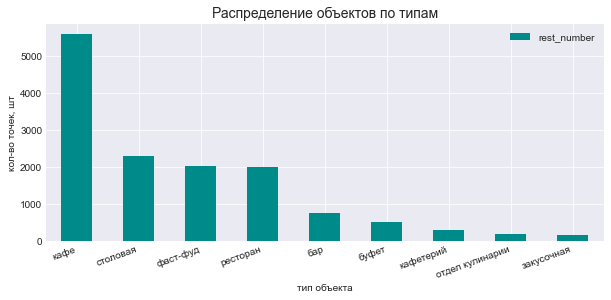

In [30]:
(rest_msc.groupby('object_type')
 .agg(rest_number = ('id', 'count'))
 .sort_values(by = 'rest_number', ascending = False)
 .plot(kind = 'bar', color = 'darkcyan', figsize = (10, 4))
)

plt.title('Распределение объектов по типам',fontdict={'size':14})
plt.ylabel('кол-во точек, шт')
plt.xlabel('тип объекта')
plt.xticks(rotation = 20, ha="right");

Среди типов заведений по количеству точек выделяется "кафе". Это наиболее распространенный тип с более чем 5000 точек в Москве. Далее идут столовая фаст-фуд и ресторан с около 2000 точек.

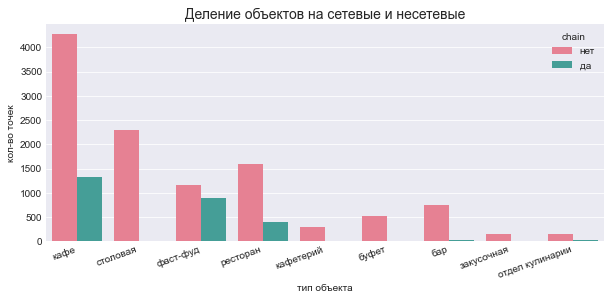

In [31]:
fig, ax = plt.subplots(figsize = (10, 4))
sns.countplot(x='object_type',
              hue='chain',
              data=rest_msc,
              palette = 'husl'
              )

plt.xticks(rotation=20, ha="right")
plt.title('Деление объектов на сетевые и несетевые', fontdict={'size':14})
plt.xlabel('тип объекта')
plt.ylabel('кол-во точек');

В целом, несетевых объектов значительно больше чем сетевых, собственно сети есть только в типах кафе, фаст-фуд и ресторан.
Наиболее характерно сетевое распространение для фаст-фуда - почти половина точек принадлежит какой-то сети (если учесть ошибки в названиях и раличные написания для отдельных юр лиц, скорее всего сетевых точек для ресторанов быстрого питания будет еще больше)

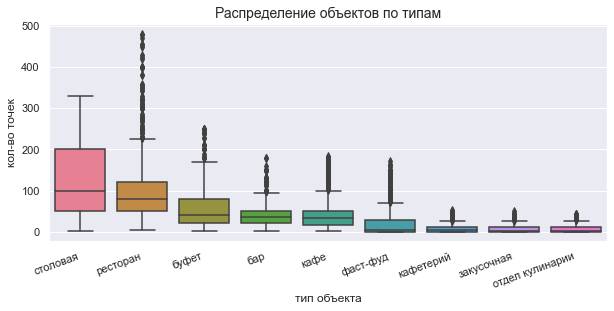

In [32]:
sns.set(rc = {'figure.figsize': (10, 4)})

order_for_bars = (rest_msc
                  .groupby(['object_type'], as_index = False)
                  .agg({'number': 'mean'})
                  .sort_values(by = 'number', ascending = False)
                  .object_type
                  .array
                 )

sns.boxplot(x = 'object_type',
            y = 'number',
            data = rest_msc,
            palette = 'husl',
            order = order_for_bars
           )

plt.xticks(rotation=20, ha="right")
plt.title('Распределение объектов по типам', fontdict={'size':14})
plt.xlabel('тип объекта')
plt.ylabel('кол-во точек');

В среднем самое большое количество посадочных мест (около 100) предоставляют столовые, что предсказуемо. Далее идут рестораны, причем разброс значений для ресторанов намного больше, чем для столовых. То есть существуют рестораны, где посадочных мест в несколько раз больше, чем в среднем в столовых. 

Меньше всего посадочных мест в закусочных и отделах кулинарии в магазинах - часто там вообще нет мест (по крайней мере судя по имеющимся данным)

In [33]:
#условие для фильтрации сетевых объектов
chain_obj_type = (rest_msc['object_type'] == 'кафе') | (rest_msc['object_type'] == 'фаст-фуд') | (rest_msc['object_type'] == 'ресторан')

In [34]:
chain_seat_number = (rest_msc[(rest_msc['chain'] == 'да') & (chain_obj_type)]
                     .groupby(['object_name', 'object_type'])
                     .agg(obj_number = ('id', 'count'),
                          seat_number = ('number', 'mean'))
                     .reset_index()
                    )

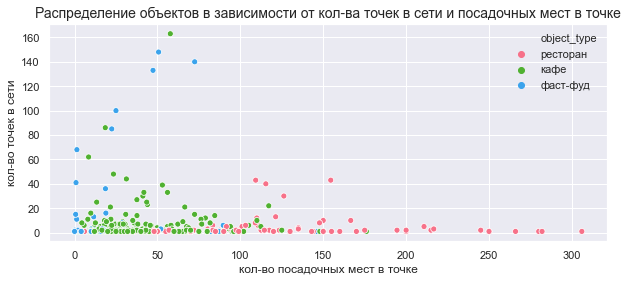

In [35]:
sns.set(rc = {'figure.figsize': (10, 4)})
sns.scatterplot(x = 'seat_number',
                y = 'obj_number',
                data = chain_seat_number,
                hue = 'object_type',
                #style = 'object_type',
                palette = 'husl',
                #legend = False,
                #s = 50
               )

plt.title('Распределение объектов в зависимости от кол-ва точек в сети и посадочных мест в точке', fontdict={'size':14})
plt.xlabel('кол-во посадочных мест в точке')
plt.ylabel('кол-во точек в сети');

В зависимости от типа заведения сети выбирают различные стратегии развития:
- для фаст-фуд сетей характерно большое количество точек в сети и небольшое количество посадочных мест,
- для ресторанов характерно небольшое количество точек, но большая вместимость,
- в кафе обычно меньше точек в сети, чем в фаст-фуд сетях, и меньше посадочных мест, чем в ресторанах.

In [36]:
#топ-10 улиц по кол-ву объектов
top_10_street = (rest_msc
                 .groupby(['street'])
                 .agg(obj_number = ('id', 'count'))
                 .sort_values(by = 'obj_number', ascending = False)
                 .head(10)
                )
top_streets_list = top_10_street.index

In [37]:
#ссылка для отрисовки точек на карте Москвы
map_url = 'https://static-maps.yandex.ru/1.x/?ll=37.617664,55.752121&size=400,400&z=13&l=map&bbox=37.36046,55.567635~37.854774,55.915993'
msc_map = plt.imread(map_url)

#ограничение по координатам для карты
bbox = (37.04046, 38.174774 , 55.427635, 56.045993)

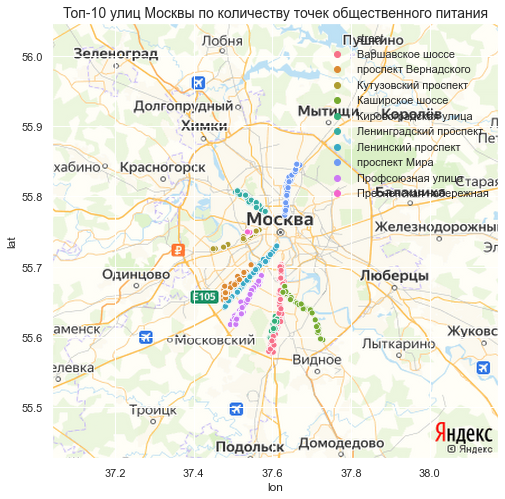

In [38]:
street_scatter = rest_msc.query('street in @top_streets_list')

fig, ax = plt.subplots(figsize = (8, 8))
sns.scatterplot(x = 'lon',
                y = 'lat',
                data = street_scatter,
                hue = 'street',
                palette = 'husl'
               )

ax.set_title('Топ-10 улиц Москвы по количеству точек общественного питания', fontdict={'size':14})
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])

ax.imshow(msc_map, zorder=0, extent = bbox, aspect= 'auto', interpolation='lanczos');

In [39]:
top_5_areas = (rest_msc
                 .groupby(['area'])
                 .agg(obj_number = ('id', 'count'))
                 .sort_values(by = 'obj_number', ascending = False)
                 .head(5)
                )
top_areas_list = top_5_areas.index

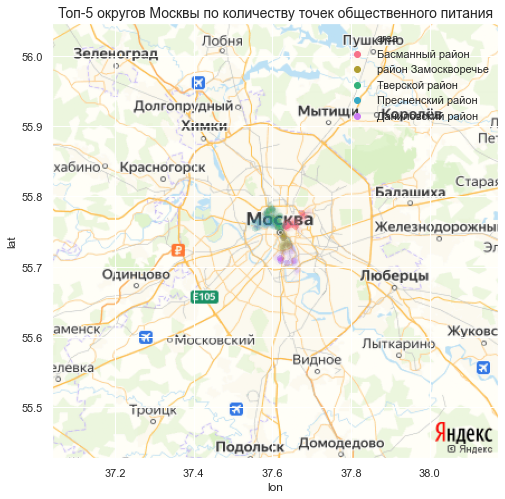

In [40]:
area_scatter = rest_msc.query('area in @top_areas_list')

fig, ax = plt.subplots(figsize = (8, 8))
sns.scatterplot(x = 'lon',
                y = 'lat',
                data = area_scatter,
                hue = 'area',
                palette = 'husl',
                alpha = 0.01
               )

ax.set_title('Топ-5 округов Москвы по количеству точек общественного питания', fontdict={'size':14})
ax.set_xlim(bbox[0],bbox[1])
ax.set_ylim(bbox[2],bbox[3])

ax.imshow(msc_map, zorder=0, extent = bbox, aspect= 'auto');

Наиболее популярные округа для открытия точек общественного питания в Москве:
- Тверской
- Басманный
- Пресненский
- Даниловский
- Замоскворечье

<a href="#back">В начало</a>

<article id="part3">
<h2>Шаг 3. Общий вывод
</article>

__Общие выводы__:
- Наиболее распространенный тип заведений общественного питания — кафе с >5000 точек в Москве.
- Более 20% кафе принадлежат какой-либо сети, но наиболее характерно сетевое распространение для заведений быстрого питания.
- Самое большое количество посадочных мест предоставляют столовые и рестораны (100 и 80 соответственно), в кафе в среднем 34 посадочных места.
- Нужно иметь в виду, что вероятно в будущем среднее количество посадочных мест в заведениях общественного питания может уменьшиться из-за изменений в законодательстве и рекомендаций Минздрава в связи с эпидемией covid-19 :-)
- Для ресторанов характерно небольшое количество точек, с большой вместимостью, для фаст-фуд сетей характерно большое количество точек в сети с маленьким количеством посадочных мест. В кафе обычно меньше точек в сети (в среднем 5), чем в фаст-фуд сетях и меньше посадочных мест, чем в ресторанах.
- Район для открытия ресторана лучше выбирать либо по количеству заведений на километр, либо по округу (Тверской, Басманный или Пресненский).